# Getting started with Task 2

Instructions:
- Download the dataset from the [ECG Heartbeat Categorization Dataset](https://www.kaggle.com/datasets/shayanfazeli/heartbeat)
- Unzip the `archive.zip` file
- Rename the folder `archive` as `ecg_dataset` and place it in the root of the git repository

References:
- [ECG Heartbeat Classification: A Deep Transferable Representation](https://arxiv.org/pdf/1805.00794.pdf)

## Load dependencies

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from keras.models import Model

# Drive
# from google.colab import drive
# drive.mount('/content/drive')

/Users/noahgallego/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## MIT-BIH  Arrhythmia Dataset

- Number of Samples: 109446
- Number of Categories: 5
- Sampling Frequency: 125Hz
- Data Source: Physionet's MIT-BIH Arrhythmia Dataset
- Classes: ['N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4]
- Remark: All the samples are cropped, downsampled and padded with zeroes if necessary to the fixed dimension of 188.
- The final element of each row denotes the class to which that example belongs.


In [ ]:
# Load and preprocess data
df_mitbih_train = pd.read_csv("~/Desktop/LLNL Cardiology Project/ecg_dataset/mitbih_test.csv", header=None)
df_mitbih_test = pd.read_csv("~/Desktop/LLNL Cardiology Project/ecg_dataset/mitbih_train.csv", header=None)
df_mitbih = pd.concat([df_mitbih_train, df_mitbih_test], axis=0)
df_mitbih.rename(columns={187: 'label'}, inplace=True)

# Separate majority and minority classes
df_majority = df_mitbih[df_mitbih.label == 0]
df_minority_classes = df_mitbih[df_mitbih.label != 0]

# Dictionary to hold resampled minority classes
resampled_minority_classes = []

# Upsample each minority class to match the majority class
for label in df_minority_classes.label.unique():
    df_minority = df_mitbih[df_mitbih.label == label]
    df_minority_upsampled = resample(df_minority,
                                     replace=True,  # sample with replacement
                                     n_samples=len(df_majority),  # to match majority class
                                     random_state=123)  # reproducible results
    resampled_minority_classes.append(df_minority_upsampled)

# Combine majority class with upsampled minority classes
df_upsampled = pd.concat([df_majority] + resampled_minority_classes,ignore_index=True)

# Verify the new class distribution
id_to_label = {
    0: "Normal",
    1: "Artial Premature",
    2: "Premature ventricular contraction",
    3: "Fusion of ventricular and normal",
    4: "Fusion of paced and normal"
}

counts = df_upsampled['label'].value_counts()
counts.index = counts.index.map(id_to_label)
plt.figure(figsize=(10, 5))
counts.plot(kind="bar")
plt.xticks(rotation=45)
plt.title("Number of samples in each class after upsampling")
plt.show()

# Separate features and target variable
X_upsampled = df_upsampled.iloc[:, :-1].values
y_upsampled = df_upsampled.iloc[:, -1].values

# Ensure labels are 1D array before using to_categorical
print("y_upsampled shape before to_categorical:", y_upsampled.shape)  # Should be (number_of_samples,)
print("Unique labels in y_upsampled:", np.unique(y_upsampled))  # Should be the class labels [0, 1, 2, 3, 4]

# Convert labels to categorical format correctly
y_upsampled = to_categorical(y_upsampled, num_classes=5)

# Check the shape of y_upsampled after to_categorical
print("y_upsampled shape after to_categorical:", y_upsampled.shape)  # Should be (number_of_samples, 5)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_upsampled, y_upsampled, test_size=0.2, random_state=42)

# Print shapes to ensure they match the model's requirements
print("X_train shape:", X_train.shape)  # Expected: (number_of_samples, 187, 1)
print("y_train shape:", y_train.shape)  # Expected: (number_of_samples, 5)
print("X_test shape:", X_test.shape)    # Expected: (number_of_samples, 187, 1)
print("y_test shape:", y_test.shape)    # Expected: (number_of_samples, 5)


y_upsampled shape before to_categorical: (452945,)
Unique labels in y_upsampled: [0. 1. 2. 3. 4.]
y_upsampled shape after to_categorical: (452945, 5)
X_train shape: (362356, 187)
y_train shape: (362356, 5)
X_test shape: (90589, 187)
y_test shape: (90589, 5)


In [ ]:
# create a figure
plt.figure(figsize = (20, 10))
# define colors for each class
colors = ["blue", "red", "green", "orange", "purple"]
# plot the normal sequences
for i in range(3):
    for label in id_to_label.keys():
        # sample a random sequence from that label
        df_mitbih_label = df_mitbih[df_mitbih["label"] == label].sample(1)
        # plot the sequence
        if i == 0:
            plt.plot(df_mitbih_label.columns[:-1], df_mitbih_label.iloc[0, :-1], label = id_to_label[label], color = colors[label])
        else:
            plt.plot(df_mitbih_label.columns[:-1], df_mitbih_label.iloc[0, :-1], color = colors[label])
# create a legend for the plot, blue for normal and red for abnormal
plt.legend()
# set the title
plt.title("ECG sequences")
# y lable is "Normalized value"
plt.ylabel("Normalized value")
# x label is "Time (ms)"
plt.xlabel("Time (ms)")
# show the plot
plt.show()
# close
plt.close()

In [ ]:
df_mitbih.head()

0         1         2         3         4         5         6  \
0  1.000000  0.758264  0.111570  0.000000  0.080579  0.078512  0.066116   
1  0.908425  0.783883  0.531136  0.362637  0.366300  0.344322  0.333333   
2  0.730088  0.212389  0.000000  0.119469  0.101770  0.101770  0.110619   
3  1.000000  0.910417  0.681250  0.472917  0.229167  0.068750  0.000000   
4  0.570470  0.399329  0.238255  0.147651  0.000000  0.003356  0.040268   

          7         8         9  ...  178  179  180  181  182  183  184  185  \
0  0.049587  0.047521  0.035124  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.307692  0.296703  0.300366  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.123894  0.115044  0.132743  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.004167  0.014583  0.054167  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.080537  0.070470  0.090604  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   186  label  
0  0.0    0.0  
1  0.0    0.0  
2  0.0    0.0  
3  0.0    0.0  
4  0.0    0.0  

[5 rows x 188 columns]

In [ ]:
# Build the Model
signal_length = X_train.shape[1]

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(signal_length, 1), name = 'first_conv'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv1D(filters = 128, kernel_size = 5, activation = 'relu', name = 'second_conv'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size = 2))
model.add(Dropout(0.2))

model.add(Conv1D(filters = 256, kernel_size = 10, activation = 'relu', name='last_conv'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size = 2))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=5, activation='softmax')) # 5 classes for N, S, V, F, Q

# Compile the Model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ first_conv (Conv1D)             │ (None, 185, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_27 (MaxPooling1D) │ (None, 92, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 92, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ second_conv (Conv1D)            │ (None, 88, 128)        │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 88, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_28 (MaxPooling1D) │ (None, 44, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 44, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ last_conv (Conv1D)              │ (None, 35, 256)        │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 35, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_29 (MaxPooling1D) │ (None, 17, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 17, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 4352)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │       557,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 928,645 (3.54 MB)

 Trainable params: 927,877 (3.54 MB)

 Non-trainable params: 768 (3.00 KB)

Epoch 1/5
5662/5662 ━━━━━━━━━━━━━━━━━━━━ 227s 40ms/step - accuracy: 0.8776 - loss: 0.3622 - val_accuracy: 0.9808 - val_loss: 0.0569
Epoch 2/5
5662/5662 ━━━━━━━━━━━━━━━━━━━━ 246s 43ms/step - accuracy: 0.9686 - loss: 0.0909 - val_accuracy: 0.9866 - val_loss: 0.0397
Epoch 3/5
5662/5662 ━━━━━━━━━━━━━━━━━━━━ 243s 43ms/step - accuracy: 0.9794 - loss: 0.0616 - val_accuracy: 0.9917 - val_loss: 0.0269
Epoch 4/5
5662/5662 ━━━━━━━━━━━━━━━━━━━━ 239s 42ms/step - accuracy: 0.9836 - loss: 0.0489 - val_accuracy: 0.9924 - val_loss: 0.0259
Epoch 5/5
5662/5662 ━━━━━━━━━━━━━━━━━━━━ 236s 42ms/step - accuracy: 0.9863 - loss: 0.0428 - val_accuracy: 0.9900 - val_loss: 0.0303
2831/2831 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.9898 - loss: 0.0305
Loss:  0.03026767633855343
Accuracy:  0.9899877309799194


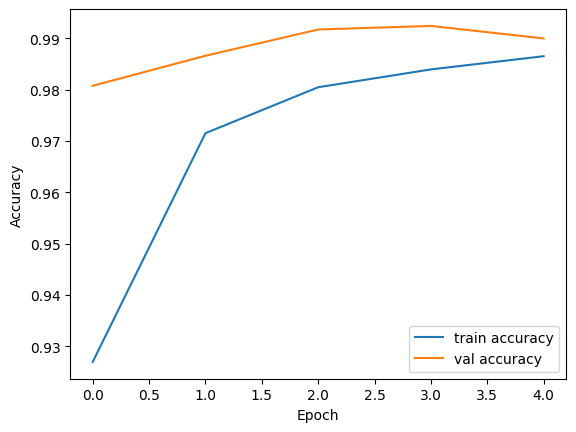

In [ ]:
# Train the Model
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))
loss, accuracy = model.evaluate(X_test, y_test)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
import tensorflow as tf
import matplotlib.cm as cm
import random

def grad_cam(model, layer_name, data, pred_index):
    # Takes original model's input and ouputs both activations of a specified layer
    # Allows us to compute gradients with respect to a desired layer
    grad_model = Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )

    print("Generating GradCAM for layer:", layer_name)

    # Compute gradients with respect to the desired layer
    with tf.GradientTape() as tape:
        # Forward pass the input
        conv_outputs, predictions = grad_model(data)
        # Compute the Loss
        loss = predictions[:, pred_index]

    # Compute the gradients
    grads = tape.gradient(loss, conv_outputs)
    # Average the gradients
    pooled_grads = tf.reduce_mean(grads, axis=0)

    # Get the activations
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

def plot_gradcam(ecg_data, cam, prediction, class_names, title='GradCAM'):
    # Plot the GradCAM
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(ecg_data.flatten(), alpha=0.8, label='ECG Signal')

    # Add the GradCAM heatmap to plot of ECG
    cax = ax.imshow(np.expand_dims(cam, axis=0), cmap='jet', aspect='auto', alpha=0.5, extent=[0, len(ecg_data.flatten()), ax.get_ylim()[0], ax.get_ylim()[1]])
    fig.colorbar(cax, ax=ax, orientation='horizontal', label='Activation Intensity')
    ax.set_title(title)
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Activation')
    ax.legend()

    # Add Classification & Prediction with Actual
    text = f'Classification: {class_names[np.argmax(prediction)]}\nPrediction: {class_names[np.argmax(y_test[sample_index])]}\nConfidence: {np.max(prediction)}'
    print(text)

    plt.show()

# Example usage on a test sample
sample_index = random.randint(0, X_test.shape[0])
sample_data = X_test[sample_index:sample_index + 1]

# Class Index
class_index = np.argmax(y_test[sample_index])

# Get GradCAM for the specified layer
layer_name = 'last_conv'
cam = grad_cam(model, layer_name, sample_data, class_index)

# Get the model prediction
prediction = model.predict(sample_data)

# Class names
class_names = list(id_to_label.values())

# Evaluate multiple samples with GradCAM
for i in range(5):
    sample_index = random.randint(0, X_test.shape[0] - 1)
    sample_data = X_test[sample_index:sample_index + 1]
    class_index = np.argmax(y_test[sample_index])
    cam = grad_cam(model, layer_name, sample_data, class_index)
    prediction = model.predict(sample_data)
    plot_gradcam(sample_data[0], cam, prediction, class_names, title=f'GradCAM for Sample {i + 1}')

/Users/noahgallego/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


NameError: name 'X_test' is not defined